# VAE Model Using Convolutional and MaxPooling Layers
Partition the physical data and define the model architecture.

## Notes
- If you want to skip inferencing at each epoch, set the test_time variable to zero.
- If you don't want to find the best model based on exponential fit of the CCDF statistic, set USE_SLOPE_CRITERION to zero in the next cell.

In [88]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress

# GPU initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model hyperparameters
latent_dim = 1024
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S.%f")
folder = f"model_at_{timestamp}"
model_weights_path = f'{folder}/model_weights_pytorch.pth'

# Custom callback equivalent for prediction evolution
class PredictionTracker:
    def __init__(self, encoder_model, decoder_model, initial_point, test_time, mean_psi, std_psi, actual_values, zonal_wind_idx=63):
        self.encoder_model = encoder_model
        self.decoder_model = decoder_model
        self.initial_point = initial_point.clone()  # Use clone() instead of copy() for PyTorch tensors
        self.test_time = test_time
        print(f"Debug: self.test_time = {self.test_time}")
        self.mean_psi = mean_psi
        self.std_psi = std_psi
        self.predictions_history = []
        self.actual_values = actual_values
        self.zonal_wind_idx = zonal_wind_idx
        
    def on_epoch_end(self, epoch, train_loss, val_loss):
        print(f"Epoch {epoch + 1}: Loss = {train_loss:.6f}, Validation Loss = {val_loss:.6f}")
        
        self.encoder_model.eval()
        self.decoder_model.eval()
        
        pred_mean = np.zeros((self.test_time, 75, 1))
        initial = self.initial_point.clone()
        
        with torch.no_grad():
            for k in tqdm(range(self.test_time), desc=f"Epoch {epoch + 1} Prediction Progress"):
                try:
                    # Get latent encoding
                    mu, log_var = self.encoder_model(initial)
                    z = self.reparameterize(mu, log_var)
                    
                    # Decode
                    pred_ens = self.decoder_model(z)
                    
                    pred_step = pred_ens.cpu().numpy().reshape(75, 1)
                    pred_mean[k, :, :] = pred_step
                    
                    # Denormalize prediction (PyTorch version of the TF code)
                    pred_denorm = (pred_step.squeeze() * self.std_psi.cpu().numpy() + 
                                   self.mean_psi.cpu().numpy()).reshape(1, 75, 1)
                    
                    # Normalize again for next input
                    initial = torch.tensor(
                        (pred_denorm - self.mean_psi.cpu().numpy().reshape(1, -1, 1)) / 
                        self.std_psi.cpu().numpy().reshape(1, -1, 1),
                        dtype=torch.float32
                    ).to(device)
                    
                except Exception as e:
                    print(f"Error during prediction at day {k}: {e}")
                    break
        
        # Denormalize final predictions
        pred_mean = pred_mean.squeeze() * self.std_psi.cpu().numpy().reshape(1, -1) + self.mean_psi.cpu().numpy().reshape(1, -1)
        pred_mean = pred_mean.reshape(self.test_time, 75, 1)
        self.predictions_history.append(pred_mean)
        
        # Save predictions and plot
        np.save(f'{folder}/predictions_epoch_{epoch+1}.npy', pred_mean)
        plt.figure(figsize=(15, 10))
        plt.plot(self.actual_values[:, self.zonal_wind_idx], 'b-', label='Actual', linewidth=2)
        plt.plot(pred_mean[:, self.zonal_wind_idx], 'r--', label=f'Predicted', linewidth=2)
        plt.title(f'Predictions vs Actual at Epoch {epoch+1}')
        plt.xlabel('Days')
        plt.ylabel('Zonal Wind Speed')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'{folder}/prediction_epoch_{epoch+1}.png')
        plt.close()
        
        # Return models to training mode
        self.encoder_model.train()
        self.decoder_model.train()
    
    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

def plot_prediction_evolution(predictions_history, actual_values, zonal_wind_idx=63):
    n_epochs = len(predictions_history)
    plt.figure(figsize=(15, 10))
    plt.plot(actual_values[:, zonal_wind_idx], 'k-', label='Actual', linewidth=2)
    
    for i, pred in enumerate(predictions_history):
        alpha = (i + 1) / n_epochs
        plt.plot(pred[:, zonal_wind_idx], alpha=alpha, 
                label=f'Epoch {i+1}', linestyle='--')
    
    plt.title(f'Evolution of Predictions at Index {zonal_wind_idx}')
    plt.xlabel('Days')
    plt.ylabel('Zonal Wind Speed')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{folder}/prediction_evolution.png')
    plt.show()

# Define PyTorch VAE model classes
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        
        # Convolutional layers with pooling (equivalent to TF model)
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1) 
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(2)
        
        # Calculate flattened size - original shape is (75, 1)
        # After 3 pooling layers: 75 -> 38 -> 19 -> 9 (slightly different from TF due to PyTorch pooling)
        self.flattened_size = 9 * 64
        
        # Latent space
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)
        
    def forward(self, x):
        # PyTorch expects [batch_size, channels, length] for Conv1d
        # So we need to permute from [batch_size, length, channels]
        x = x.permute(0, 2, 1)
        
        # Apply convolution and pooling layers with ReLU activations
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        # Get latent parameters
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        
        # First reshape from latent space to match encoder's flattened shape
        self.latent_to_features = nn.Linear(latent_dim, 10 * 64)
        
        # Transpose convolutions (equivalent to upsampling + conv in TensorFlow)
        self.tconv1 = nn.ConvTranspose1d(64, 64, kernel_size=3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.tconv2 = nn.ConvTranspose1d(64, 64, kernel_size=3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2) 
        self.tconv3 = nn.ConvTranspose1d(64, 64, kernel_size=3, padding=1)
        self.upsample3 = nn.Upsample(scale_factor=2)
        
        # Final output layer
        self.tconv_final = nn.ConvTranspose1d(64, 1, kernel_size=3, padding=1)
        
    def forward(self, z):
        # Reshape from latent dimension
        x = torch.relu(self.latent_to_features(z))
        x = x.view(-1, 64, 10)  # Reshape to [batch, channels, length]
        
        # Apply transpose convolutions with upsampling
        x = torch.relu(self.tconv1(x))
        x = self.upsample1(x)
        x = torch.relu(self.tconv2(x))
        x = self.upsample2(x)
        x = torch.relu(self.tconv3(x))
        x = self.upsample3(x)
        
        # Final layer and crop to match input shape (75, 1)
        x = self.tconv_final(x)
        x = x[:, :, :75]  # Crop to ensure correct output size
        
        # Convert back to [batch, length, channels] format
        x = x.permute(0, 2, 1)
        
        return x

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        
    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var
    
    def loss_function(self, recon_x, x, mu, log_var, beta=5):
        """
        Calculates VAE loss = reconstruction loss + KL divergence loss
        """
        # Reconstruction loss (MSE)
        recon_loss = torch.nn.functional.mse_loss(recon_x, x, reduction='mean')
        
        # KL divergence loss
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Total loss with beta weighting for KL term
        return recon_loss + beta * kl_loss, recon_loss, kl_loss

# Load and preprocess data (similar to TF code)
F = np.load(r'C:\Users\danie\OneDrive\Desktop\work_torch\long_run_310k.npy')
psi = F[3500:, 0, :]

# Normalize data
mean_psi = np.mean(psi, axis=0, keepdims=True)
std_psi = np.std(psi, axis=0, keepdims=True)
std_psi = np.maximum(std_psi, 1e-8) # Stop gradient explosion
psi = (psi - mean_psi) / std_psi

# Data preparation (same as TF code)
train_size = 220000
val_size = 50000
test_time = 0
lead = 1

# Define indices for splitting
train_end = train_size
val_start = train_end
val_end = val_start + val_size

# Training data
psi_input_Tr = psi[:train_end, :].reshape(-1, 75, 1)
psi_label_Tr = psi[:train_end, :].reshape(-1, 75, 1)

# Validation data
psi_input_val = psi[val_start:val_end, :].reshape(-1, 75, 1)
psi_label_val = psi[val_start + lead:val_end + lead, :].reshape(-1, 75, 1)

# Test set size (10% of the dataset)
test_size = int(0.1 * psi.shape[0])

# Define test inputs and labels
psi_test_input = psi[val_end:val_end + test_size, :].reshape(-1, 75, 1)
psi_test_label = psi[val_end + lead:val_end + lead + test_size, :].reshape(-1, 75, 1)

# Define initial point for inference
initial_point = psi[val_end, :].reshape(1, 75, 1)

# Actual values corresponding to the test set for plotting
actual_values = (psi_test_label[:test_time, :, :].squeeze() * std_psi + mean_psi)

print(f"Shape of psi: {psi.shape}")
print(f"Train input shape: {psi_input_Tr.shape}")
print(f"Train label shape: {psi_label_Tr.shape}")
print(f"Validation input shape: {psi_input_val.shape}")
print(f"Validation label shape: {psi_label_val.shape}")
print(f"Test input shape: {psi_test_input.shape}")
print(f"Test label shape: {psi_test_label.shape}")
print(f"Initial point shape: {initial_point.shape}")

psi_input_Tr_tensor = torch.FloatTensor(psi_input_Tr).to(device)
psi_label_Tr_tensor = torch.FloatTensor(psi_label_Tr).to(device)
psi_input_val_tensor = torch.FloatTensor(psi_input_val).to(device)
psi_label_val_tensor = torch.FloatTensor(psi_label_val).to(device)
psi_test_input_tensor = torch.FloatTensor(psi_test_input).to(device)
psi_test_label_tensor = torch.FloatTensor(psi_test_label).to(device)
initial_point_tensor = torch.FloatTensor(initial_point).to(device)

# DataLoaders
train_dataset = TensorDataset(psi_input_Tr_tensor, psi_label_Tr_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
print(psi_input_Tr.shape)
print(psi_label_Tr.shape)

val_dataset = TensorDataset(psi_input_val_tensor, psi_label_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

mean_psi_tensor = torch.FloatTensor(mean_psi).to(device)
std_psi_tensor = torch.FloatTensor(std_psi).to(device)

# Initialize
vae = VAE(latent_dim).to(device)
optimizer = optim.Adam(vae.parameters())
torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)

# Early stopping
best_val_loss = float('inf')
patience = 20
patience_counter = 0

# Prediction tracker
pred_tracker = PredictionTracker(
    vae.encoder, 
    vae.decoder, 
    initial_point_tensor, 
    test_time, 
    mean_psi_tensor, 
    std_psi_tensor, 
    actual_values, 
    zonal_wind_idx=63
)

# Training loop
def train_epoch(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    recon_loss_sum = 0
    kl_loss_sum = 0
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} Training")):
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        loss, recon_loss, kl_loss = model.loss_function(recon_batch, target, mu, log_var)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss_sum += recon_loss.item()
        kl_loss_sum += kl_loss.item()
    
    avg_loss = train_loss / len(train_loader)
    avg_recon_loss = recon_loss_sum / len(train_loader)
    avg_kl_loss = kl_loss_sum / len(train_loader)
    
    print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.6f}, Recon Loss = {avg_recon_loss:.6f}, KL Loss = {avg_kl_loss:.6f}")
    return avg_loss

def validate(model, val_loader):
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for data, target in tqdm(val_loader, desc="Validation"):
            recon_batch, mu, log_var = model(data)
            loss, _, _ = model.loss_function(recon_batch, target, mu, log_var)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss = {avg_val_loss:.6f}")
    return avg_val_loss

Using device: cuda
Shape of psi: (306200, 75)
Train input shape: (220000, 75, 1)
Train label shape: (220000, 75, 1)
Validation input shape: (50000, 75, 1)
Validation label shape: (50000, 75, 1)
Test input shape: (30620, 75, 1)
Test label shape: (30620, 75, 1)
Initial point shape: (1, 75, 1)
(220000, 75, 1)
(220000, 75, 1)
Debug: self.test_time = 0


# Train the Model
## Plot / Save out the predictions at each epoch
At each epoch there are weights that are saved out. Using those weights make an inference given the set amount of time. Find the weight with the least amount of loss and save it out as the "best model".

In [ ]:
# === CONFIGURATION ===
USE_SLOPE_CRITERION = 1  # Toggle slope-based best model selection
CCDF_LEVEL = 61             # Vertical level used for CCDF slope calculations
UPPER_BOUND = 53.8 / 2.8935
LOWER_BOUND = 1.75 / 2.8935

# === Pre-calculate real data CCDF slope ===
def calculate_transition_durations(y_values, upper_bound, lower_bound):
    times_between_transitions = []
    transition_start = None
    above_upper = False
    below_lower = False

    for i in range(1, len(y_values)):
        if y_values[i] < lower_bound:
            below_lower = True
            above_upper = False
        elif y_values[i] > upper_bound:
            if below_lower and transition_start is not None:
                times_between_transitions.append(i - transition_start)
                transition_start = None
            above_upper = True
            below_lower = False

        if below_lower and transition_start is None:
            transition_start = i

    return times_between_transitions

# Load the real data 1D time series at the specific level
real_data = np.load(r"C:\Users\danie\OneDrive\Desktop\work_torch\long_run_310k.npy")
real_data_1d = real_data[:, 1, CCDF_LEVEL]

# Compute CCDF slope for real data
real_durations = calculate_transition_durations(real_data_1d, UPPER_BOUND, LOWER_BOUND)
real_data_sorted = np.sort(real_durations)
ccdf_real = 1 - np.arange(1, len(real_data_sorted) + 1) / len(real_data_sorted)

valid_indices_real = ccdf_real > 0
x_fit_real = real_data_sorted[valid_indices_real]
y_fit_real = np.log(ccdf_real[valid_indices_real])

slope_real, intercept_real, *_ = linregress(x_fit_real, y_fit_real)
print(f"Reference Real Data CCDF Slope: {slope_real}")

# === TRAINING SETUP ===
train_losses = []
val_losses = []
num_epochs = 5
best_val_loss = float('inf')
best_slope_diff = float('inf')

# Check if pre-trained weights exist
if os.path.exists(model_weights_path):
    vae.load_state_dict(torch.load(model_weights_path, weights_only=True))
    print(f"Model weights loaded from {model_weights_path}.")
else:
    print(f"No pre-trained weights found. Training model...")

    os.makedirs(folder)

    for epoch in range(num_epochs):
        # === TRAIN ===
        train_loss = train_epoch(vae, train_loader, optimizer, epoch)
        train_losses.append(train_loss)

        # === VALIDATE ===
        val_loss = validate(vae, val_loader)
        val_losses.append(val_loss)

        # Run prediction tracking
        pred_tracker.on_epoch_end(epoch, train_loss, val_loss)

        # === SAVE CHECKPOINT ===
        torch.save(vae.state_dict(), f"{folder}/checkpoint_{epoch+1}")
        print(f"Checkpoint saved at epoch {epoch+1}.")

        # === VALIDATION LOSS CRITERION ===
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(vae.state_dict(), f"{folder}/best_model_val_loss")
            print(f"New best model saved based on validation loss: {best_val_loss:.6f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}.")
                break

        # === CCDF SLOPE MATCHING CRITERION ===
        if USE_SLOPE_CRITERION:
            print("\nStarting inference for CCDF slope evaluation...")

            # Inference setup
            inference_steps = 300000  # Ensure this matches the real data
            pred_mean = np.zeros((inference_steps, 75, 1))

            vae.eval()
            with torch.amp.autocast("cuda"):
                with torch.no_grad():
                    current_input = initial_point_tensor.clone()

                    for k in tqdm(range(inference_steps), desc=f"Inference Epoch {epoch+1}"):
                        mu, log_var = vae.encoder(current_input)
                        z = vae.reparameterize(mu, log_var)
                        pred_step = vae.decoder(z)

                        pred_mean[k, :, :] = pred_step.cpu().numpy()

                        # Denormalize current prediction before using as next input
                        pred_denorm = (pred_step.squeeze().cpu().numpy() * std_psi.squeeze() + mean_psi.squeeze()).reshape(1, 75, 1)

                        # Normalize again for next input
                        current_input = torch.tensor(
                            (pred_denorm - mean_psi.reshape(1, -1, 1)) / std_psi.reshape(1, -1, 1),
                            dtype=torch.float32
                        ).to(device)

            # Denormalize entire sequence
            pred_mean = pred_mean.squeeze() * std_psi.reshape(1, -1) + mean_psi.reshape(1, -1)
            pred_mean = pred_mean.reshape(inference_steps, 75, 1)

            # CCDF slope for predictions
            predictions_1d = pred_mean[:, CCDF_LEVEL, 0]
            pred_durations = calculate_transition_durations(predictions_1d, UPPER_BOUND, LOWER_BOUND)

            if len(pred_durations) > 0:
                pred_data_sorted = np.sort(pred_durations)
                ccdf_pred = 1 - np.arange(1, len(pred_data_sorted) + 1) / len(pred_data_sorted)

                valid_indices_pred = ccdf_pred > 0
                x_fit_pred = pred_data_sorted[valid_indices_pred]
                y_fit_pred = np.log(ccdf_pred[valid_indices_pred])

                slope_pred, intercept_pred, *_ = linregress(x_fit_pred, y_fit_pred)
                slope_diff = abs(slope_pred - slope_real)

                print(f"Slope difference at epoch {epoch+1}: {slope_diff:.6f}")

                if slope_diff < best_slope_diff:
                    best_slope_diff = slope_diff
                    torch.save(vae.state_dict(), f"{folder}/best_model_slope{slope_pred}")
                    print(f"New best model saved based on CCDF slope difference: {slope_diff:.6f}")
            else:
                print("No transitions detected in predictions for CCDF slope evaluation.")

    # === SAVE TRAINING HISTORY ===
    np.save(f'{folder}/train_loss.npy', np.array(train_losses))
    np.save(f'{folder}/val_loss.npy', np.array(val_losses))

# === FINAL INFERENCE ===
print("\nStarting final inference...")

pred_mean = np.zeros((test_time, 75, 1))

vae.eval()

std_psi_tensor = std_psi_tensor.view(1, 75)
mean_psi_tensor = mean_psi_tensor.view(1, 75)

with torch.amp.autocast("cuda"):
    with torch.no_grad():
        current_input = initial_point_tensor.clone()

        for k in tqdm(range(test_time), desc="Final Inference Progress"):
            mu, log_var = vae.encoder(current_input)
            z = vae.reparameterize(mu, log_var)

            pred_step = vae.decoder(z)
            pred_mean[k, :, :] = pred_step.cpu().numpy()

            pred_denorm = (pred_step.squeeze().cpu().numpy() * std_psi.squeeze() + mean_psi.squeeze()).reshape(1, 75, 1)

            current_input = torch.tensor(
                (pred_denorm - mean_psi.reshape(1, -1, 1)) / std_psi.reshape(1, -1, 1),
                dtype=torch.float32
            ).to(device)

# Denormalize final predictions
pred_mean = pred_mean.squeeze() * std_psi.reshape(1, -1) + mean_psi.reshape(1, -1)
pred_mean = pred_mean.reshape(test_time, 75, 1)

# Calculate Mean Squared Error
if (test_time>0):
    pred_flat = pred_mean.reshape(test_time, 75)
    actual_flat = actual_values
    mse_value = mean_squared_error(actual_flat, pred_flat)
    print(f"\nFinal Mean Squared Error: {mse_value:.6f}")

# Plot predictions vs actual for specific index
zonal_wind_idx = 63
plt.figure(figsize=(10, 8))
plt.plot(actual_values[:, zonal_wind_idx], label="Actual", color="blue")
plt.plot(pred_mean[:, zonal_wind_idx], label="Predicted", linestyle="dashed", color="red")
plt.title("Predictions vs Actual Values")
plt.xlabel("Time Steps")
plt.ylabel("Zonal Wind Speed")
plt.legend()
plt.grid(True)
plt.savefig(f'{folder}/predictions_vs_actual.png')
plt.show()

# Save results
torch.save({
    'predictions': torch.tensor(pred_mean),
    'mean_psi': mean_psi_tensor.cpu(),
    'std_psi': std_psi_tensor.cpu(),
    'actual_values': torch.tensor(actual_values)
}, f'{folder}/model_results.pt')

# Plot training history
try:
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.title('Training and Validation Loss over Epochs')
    plt.savefig(f'{folder}/loss_plot.png')
    plt.show()
except Exception as e:
    print(f"Could not plot training history: {e}")

Reference Real Data CCDF Slope: -0.0012396250389738006
No pre-trained weights found. Training model...


Epoch 1 Training: 100%|██████████| 215/215 [00:08<00:00, 26.21it/s]


Epoch 1: Train Loss = 0.271651, Recon Loss = 0.197911, KL Loss = 0.014748


Validation: 100%|██████████| 49/49 [00:01<00:00, 45.82it/s]


Validation Loss = 0.204474
Epoch 1: Loss = 0.271651, Validation Loss = 0.204474


Epoch 1 Prediction Progress: 0it [00:00, ?it/s]


Checkpoint saved at epoch 1.
New best model saved based on validation loss: 0.204474

Starting inference for CCDF slope evaluation...


Inference Epoch 1: 100%|██████████| 300000/300000 [12:06<00:00, 412.96it/s]


Slope difference at epoch 1: 0.005366
New best model saved based on CCDF slope difference: 0.005366


Epoch 2 Training: 100%|██████████| 215/215 [00:08<00:00, 26.20it/s]


Epoch 2: Train Loss = 0.165386, Recon Loss = 0.090583, KL Loss = 0.014960


Validation: 100%|██████████| 49/49 [00:01<00:00, 47.55it/s]


Validation Loss = 0.190406
Epoch 2: Loss = 0.165386, Validation Loss = 0.190406


Epoch 2 Prediction Progress: 0it [00:00, ?it/s]


Checkpoint saved at epoch 2.
New best model saved based on validation loss: 0.190406

Starting inference for CCDF slope evaluation...


Inference Epoch 2: 100%|██████████| 300000/300000 [12:01<00:00, 415.53it/s]


Slope difference at epoch 2: 0.000087
New best model saved based on CCDF slope difference: 0.000087


Epoch 3 Training: 100%|██████████| 215/215 [00:08<00:00, 25.65it/s]


Epoch 3: Train Loss = 0.156562, Recon Loss = 0.082879, KL Loss = 0.014737


Validation: 100%|██████████| 49/49 [00:01<00:00, 36.47it/s]


Validation Loss = 0.189542
Epoch 3: Loss = 0.156562, Validation Loss = 0.189542


Epoch 3 Prediction Progress: 0it [00:00, ?it/s]


Checkpoint saved at epoch 3.
New best model saved based on validation loss: 0.189542

Starting inference for CCDF slope evaluation...


Inference Epoch 3: 100%|██████████| 300000/300000 [12:28<00:00, 400.92it/s]


Slope difference at epoch 3: 0.001883


Epoch 4 Training: 100%|██████████| 215/215 [00:07<00:00, 27.25it/s]


Epoch 4: Train Loss = 0.150983, Recon Loss = 0.078079, KL Loss = 0.014581


Validation: 100%|██████████| 49/49 [00:00<00:00, 55.84it/s]


Validation Loss = 0.180801
Epoch 4: Loss = 0.150983, Validation Loss = 0.180801


Epoch 4 Prediction Progress: 0it [00:00, ?it/s]


Checkpoint saved at epoch 4.
New best model saved based on validation loss: 0.180801

Starting inference for CCDF slope evaluation...


Inference Epoch 4: 100%|██████████| 300000/300000 [12:32<00:00, 398.86it/s]


Slope difference at epoch 4: 0.002110


Epoch 5 Training: 100%|██████████| 215/215 [00:08<00:00, 26.44it/s]


Epoch 5: Train Loss = 0.144459, Recon Loss = 0.073445, KL Loss = 0.014203


Validation: 100%|██████████| 49/49 [00:01<00:00, 44.28it/s]


Validation Loss = 0.175914
Epoch 5: Loss = 0.144459, Validation Loss = 0.175914


Epoch 5 Prediction Progress: 0it [00:00, ?it/s]


Checkpoint saved at epoch 5.
New best model saved based on validation loss: 0.175914

Starting inference for CCDF slope evaluation...


Inference Epoch 5: 100%|██████████| 300000/300000 [11:51<00:00, 421.53it/s]


Slope difference at epoch 5: 0.000466

Starting final inference...


Final Inference Progress: 0it [00:00, ?it/s]


ValueError: Found array with 0 sample(s) (shape=(0, 75)) while a minimum of 1 is required.

# Separate inference
Make a singular inference using the "best_model_val_loss" or "best_model_slope" weights. These weights are determined by finding which weights had the least amount of loss and which weights exponential fit had the closest value to that of the physical data. It's possible to change which weights you use based on the model_weights_path variable.

- Modify "test_time" based on the amount of time steps required

Model weights loaded from C:\Users\danie\OneDrive\Desktop\work_torch\model_at_2025-03-21_13-17-29.367448\best_model_slope.

Starting inference...
(20000, 75, 1)
(20000, 75)


Inference Progress: 100%|██████████| 20000/20000 [00:48<00:00, 409.06it/s]



Mean Squared Error: 89.59255208221506


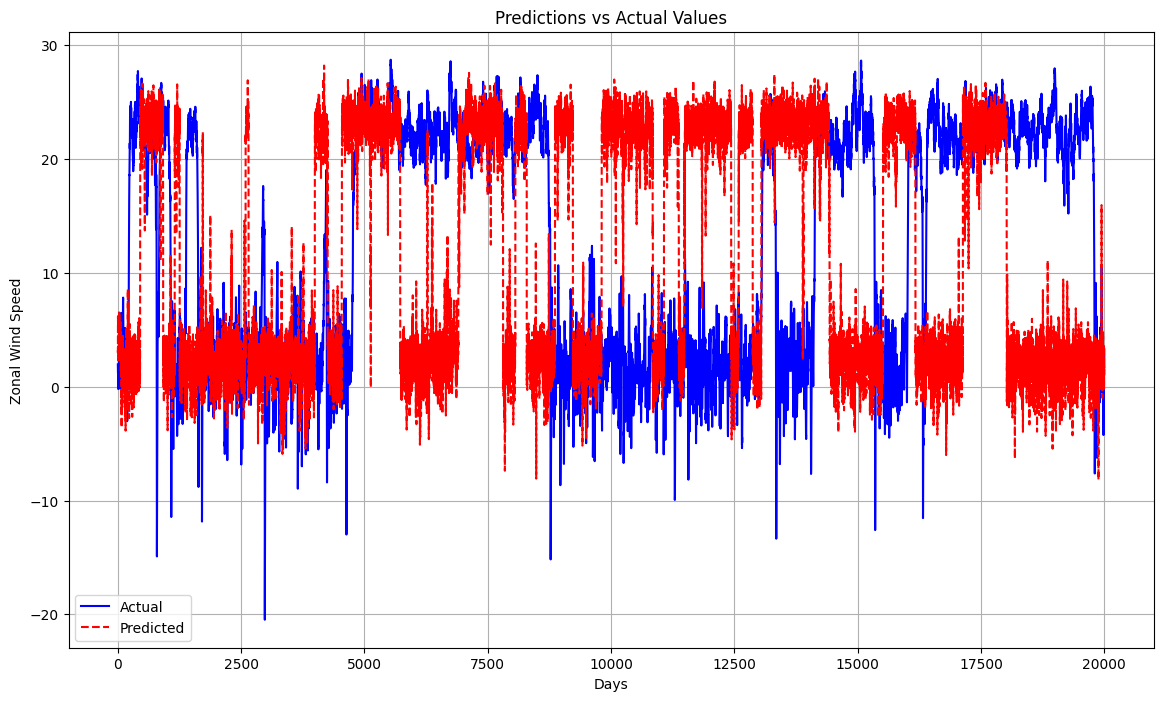

In [92]:
model_weights_path = r"C:\Users\danie\OneDrive\Desktop\work_torch\model_at_2025-03-21_13-17-29.367448\best_model_slope"

test_time = 20000

if os.path.exists(model_weights_path):
    vae.load_state_dict(torch.load(model_weights_path, weights_only=True))
    print(f"Model weights loaded from {model_weights_path}.")

# Inference
print("\nStarting inference...")
pred_mean = np.zeros((test_time, 75, 1))

# Ensure model is in evaluation mode
vae.eval()
initial_point = psi[0, :].reshape(1, 75, 1)
initial_point_tensor = torch.FloatTensor(initial_point).to(device)
psi_test_label = psi[:, :].reshape(-1, 75, 1)
print(psi_test_label[:test_time, :, :].shape)
actual_values = (psi_test_label[:test_time, :, :].squeeze() * std_psi + mean_psi)
print(actual_values.shape)
# Ensure correct shape of std_psi and mean_psi tensors
std_psi_tensor = std_psi_tensor.view(1, 75)
mean_psi_tensor = mean_psi_tensor.view(1, 75)

with torch.amp.autocast("cuda"):
# No gradient tracking needed for inference
    with torch.no_grad():
        # Set initial point
        current_input = initial_point_tensor.clone()
        
        # Inference loop with proper normalization
        for k in tqdm(range(test_time), desc="Inference Progress"):
            # Get latent encoding
            mu, log_var = vae.encoder(current_input)
            z = vae.reparameterize(mu, log_var)
            
            # Decode
            pred_step = vae.decoder(z)
            
            if torch.isnan(pred_step).any():
                print(f"NaN detected at day {k}")
                print(f"mu values: {mu}")
                print(f"log_var values: {log_var}")
                print(f"z values: {z}")
                break

            pred_mean[k, :, :] = pred_step.cpu().numpy()
            # Denormalize current prediction before using as next input
            pred_denorm = (pred_step.squeeze().cpu().numpy() * std_psi.squeeze() + mean_psi.squeeze()).reshape(1, 75, 1)
            
            # Normalize again for next input
            current_input = torch.tensor(
                (pred_denorm - mean_psi.reshape(1, -1, 1)) / std_psi.reshape(1, -1, 1),
                dtype=torch.float32
            ).to(device)

# Denormalize final predictions
pred_mean = pred_mean.squeeze() * std_psi.reshape(1, -1) + mean_psi.reshape(1, -1)
pred_mean = pred_mean.reshape(test_time, 75, 1)

# Calculate Mean Squared Error
pred_flat = pred_mean.reshape(test_time, 75)
actual_flat = actual_values
mse_value = mean_squared_error(actual_flat, pred_flat)
print(f"\nMean Squared Error: {mse_value}")

# Plot predictions vs actual for specific index
zonal_wind_idx = 63
plt.figure(figsize=(14, 8))
plt.plot(actual_values[:, zonal_wind_idx], label="Actual", color="blue")
plt.plot(pred_mean[:, zonal_wind_idx], label="Predicted", linestyle="dashed", color="red")
plt.title("Predictions vs Actual Values")
plt.xlabel("Days")
plt.ylabel("Zonal Wind Speed")
plt.legend()
plt.grid(True)
plt.savefig('predictions_vs_actual.png')
plt.show()

# Save results
torch.save({
    'predictions': torch.tensor(pred_mean),
    'mean_psi': mean_psi_tensor.cpu(),
    'std_psi': std_psi_tensor.cpu(),
    'actual_values': torch.tensor(actual_values)
}, 'model_results.pt')

np.save(f'predictions_checkpoint_38.npy', pred_mean)

# Testing the Predictive Model

## Overview
This section outlines our testing strategy to validate the accuracy, robustness, and reliability of our predictive model. Rigorous testing is critical to ensure that our model performs well under various tests.
Set flags to 1 based on which metric(s) you would like to test.

In the next cell are the flags and some basic parameters.

In [113]:
#FLAGS to determine testing
plot_data = 0
#what level do you want to plot
level = 61
CCDF = 0
Bi_modal_distribution = 0
single_step_profiles = 1
#for the single_step_profiles
NUM_SAMPLES = 5
#what weights do you want to use?
MODEL_PATH = r"C:\Users\danie\OneDrive\Desktop\work_torch\model_at_2025-03-21_13-17-29.367448\best_model_slope"
LEVEL = 61

There are two paths here that you will manually set. One to the physical data and the other to the predictions. 
# WARNING
Unless you're running new tests...
Do not run this cell multiple times after testing as it will create a new folder based on your current time!
You may have to change the lines after data initialization to match the shapes of your predictions and or physical data!

In [114]:
#Initialize Data
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

# Load the data; shape = (300000, 2, 75)
real_data = np.load(r"C:\Users\danie\OneDrive\Desktop\work_torch\long_run_310k.npy")
predictions = np.load(r"C:\Users\danie\OneDrive\Desktop\work_torch\predictions_main.npy")

#reshape the predictions so that it matches the real_data shape
predictions = predictions.reshape(300000, 1, 75)
print(predictions.shape)
print(real_data.shape)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S.%f")
folder = f"testing_at_{timestamp}"
os.mkdir(folder)
subfolders = ['timeseries', 'CCDF', 'Bi_modal_distribution', 'single_step_profiles']
# Create each subdirectory inside the main folder
for subfolder in subfolders:
    path = os.path.join(folder, subfolder)
    os.mkdir(path)
    print(f"Created subfolder: {path}")
SAVE_DIR = os.path.join(folder, "single_step_profiles")


(300000, 1, 75)
(309700, 2, 75)
Created subfolder: testing_at_2025-03-21_18-00-22.334851\timeseries
Created subfolder: testing_at_2025-03-21_18-00-22.334851\CCDF
Created subfolder: testing_at_2025-03-21_18-00-22.334851\Bi_modal_distribution
Created subfolder: testing_at_2025-03-21_18-00-22.334851\single_step_profiles


C:\Users\danie\AppData\Local\Temp\ipykernel_46500\2127797130.py:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(MODEL_PATH))


Randomly sampled time steps: [172383, 211691, 184556, 241788, 139647]


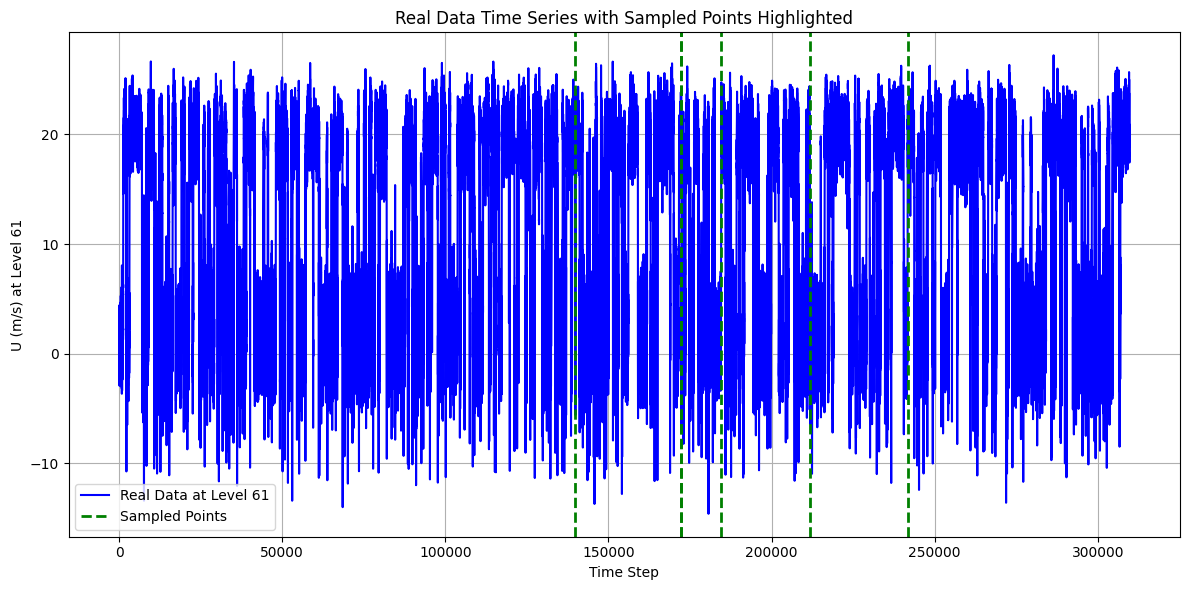

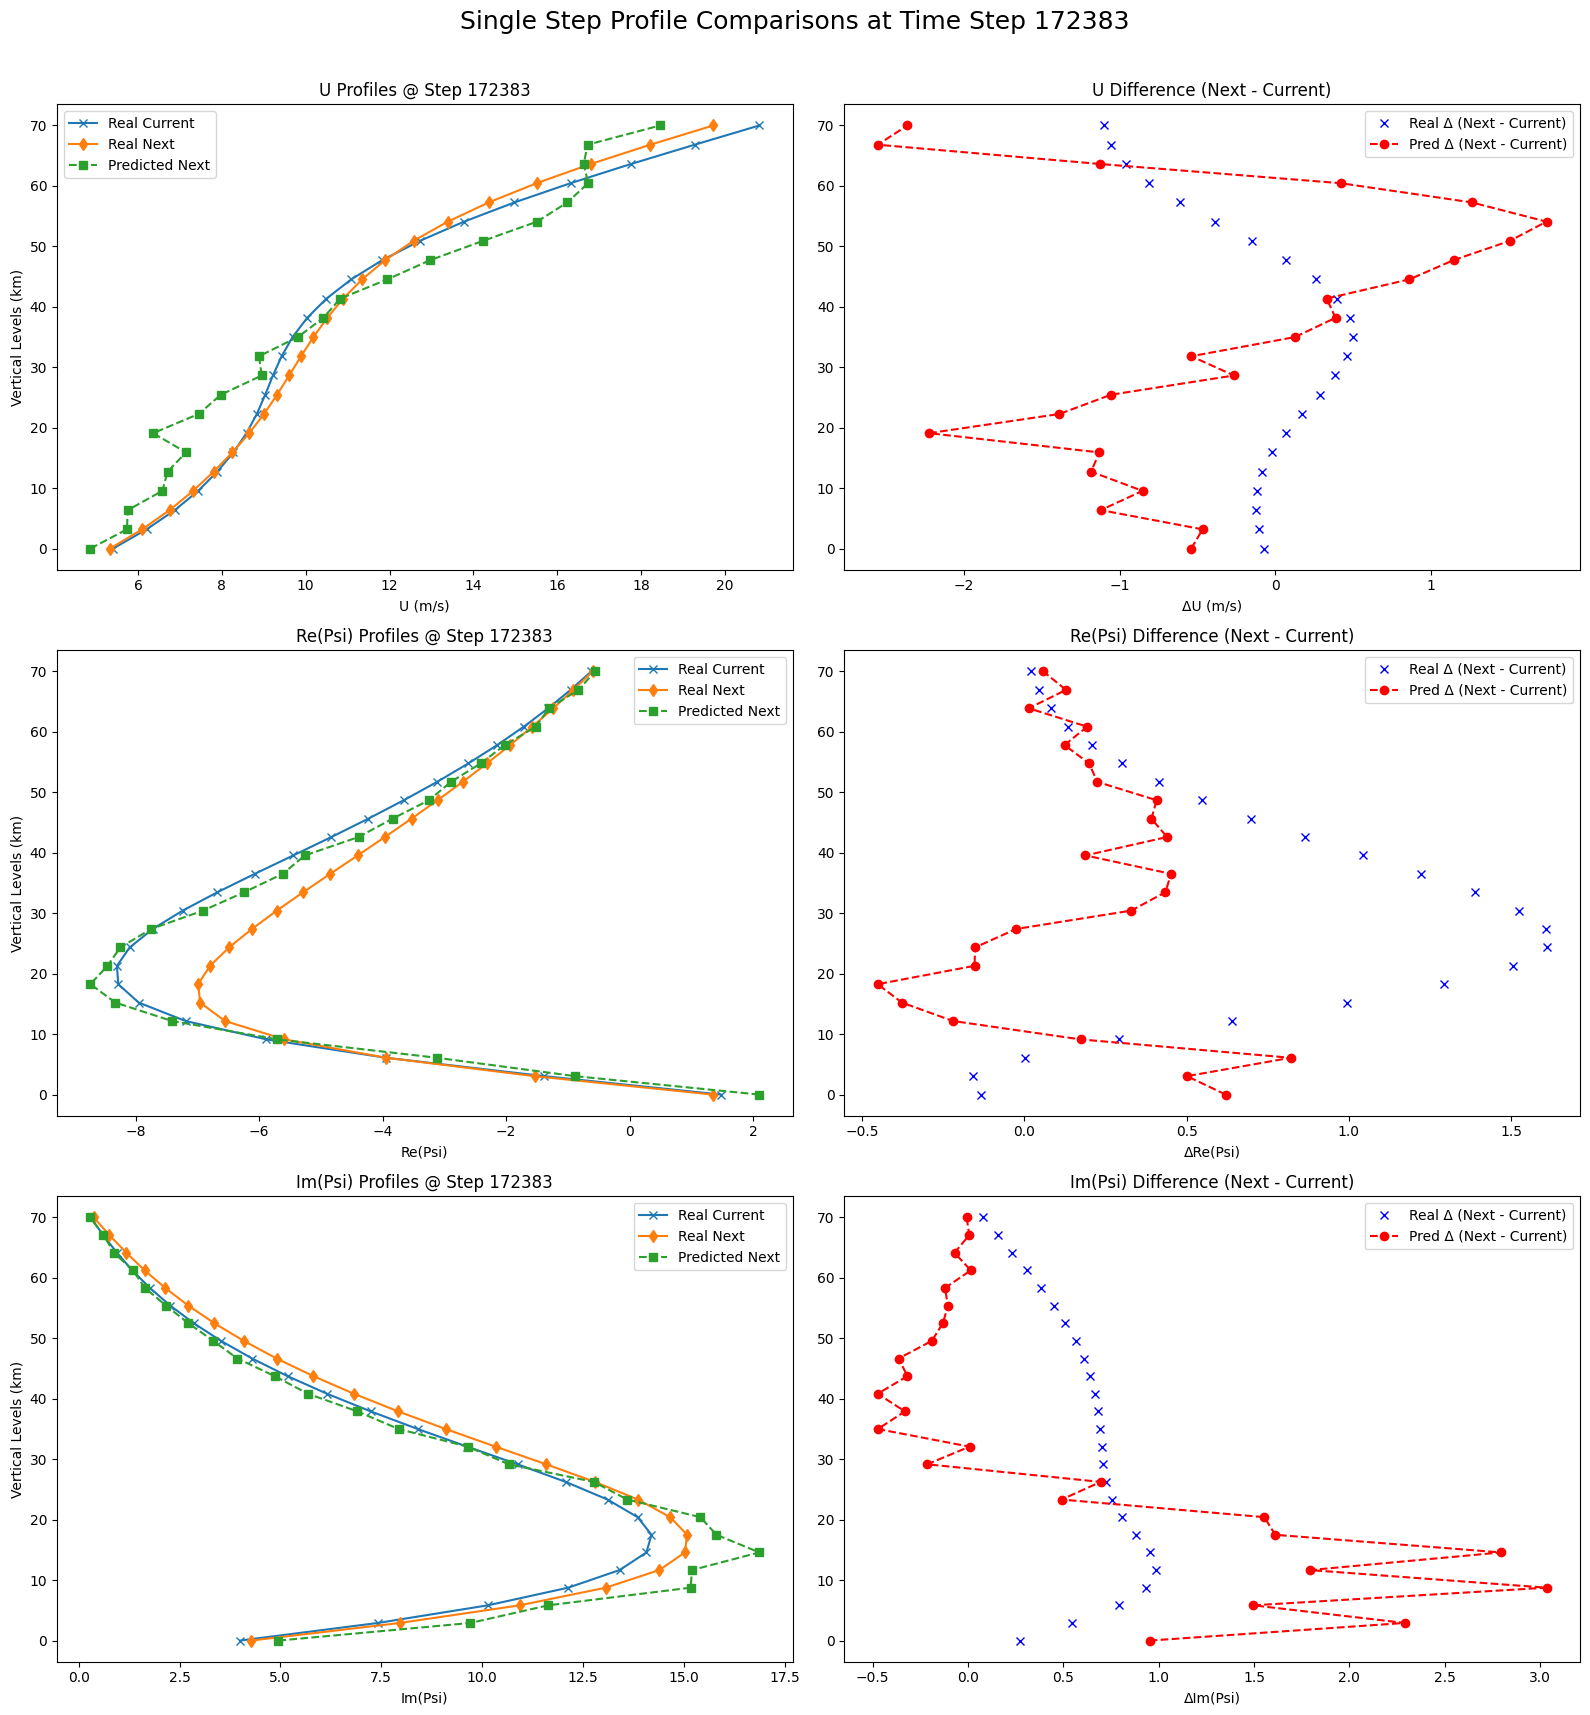

Combined plot saved for sampled point 172383


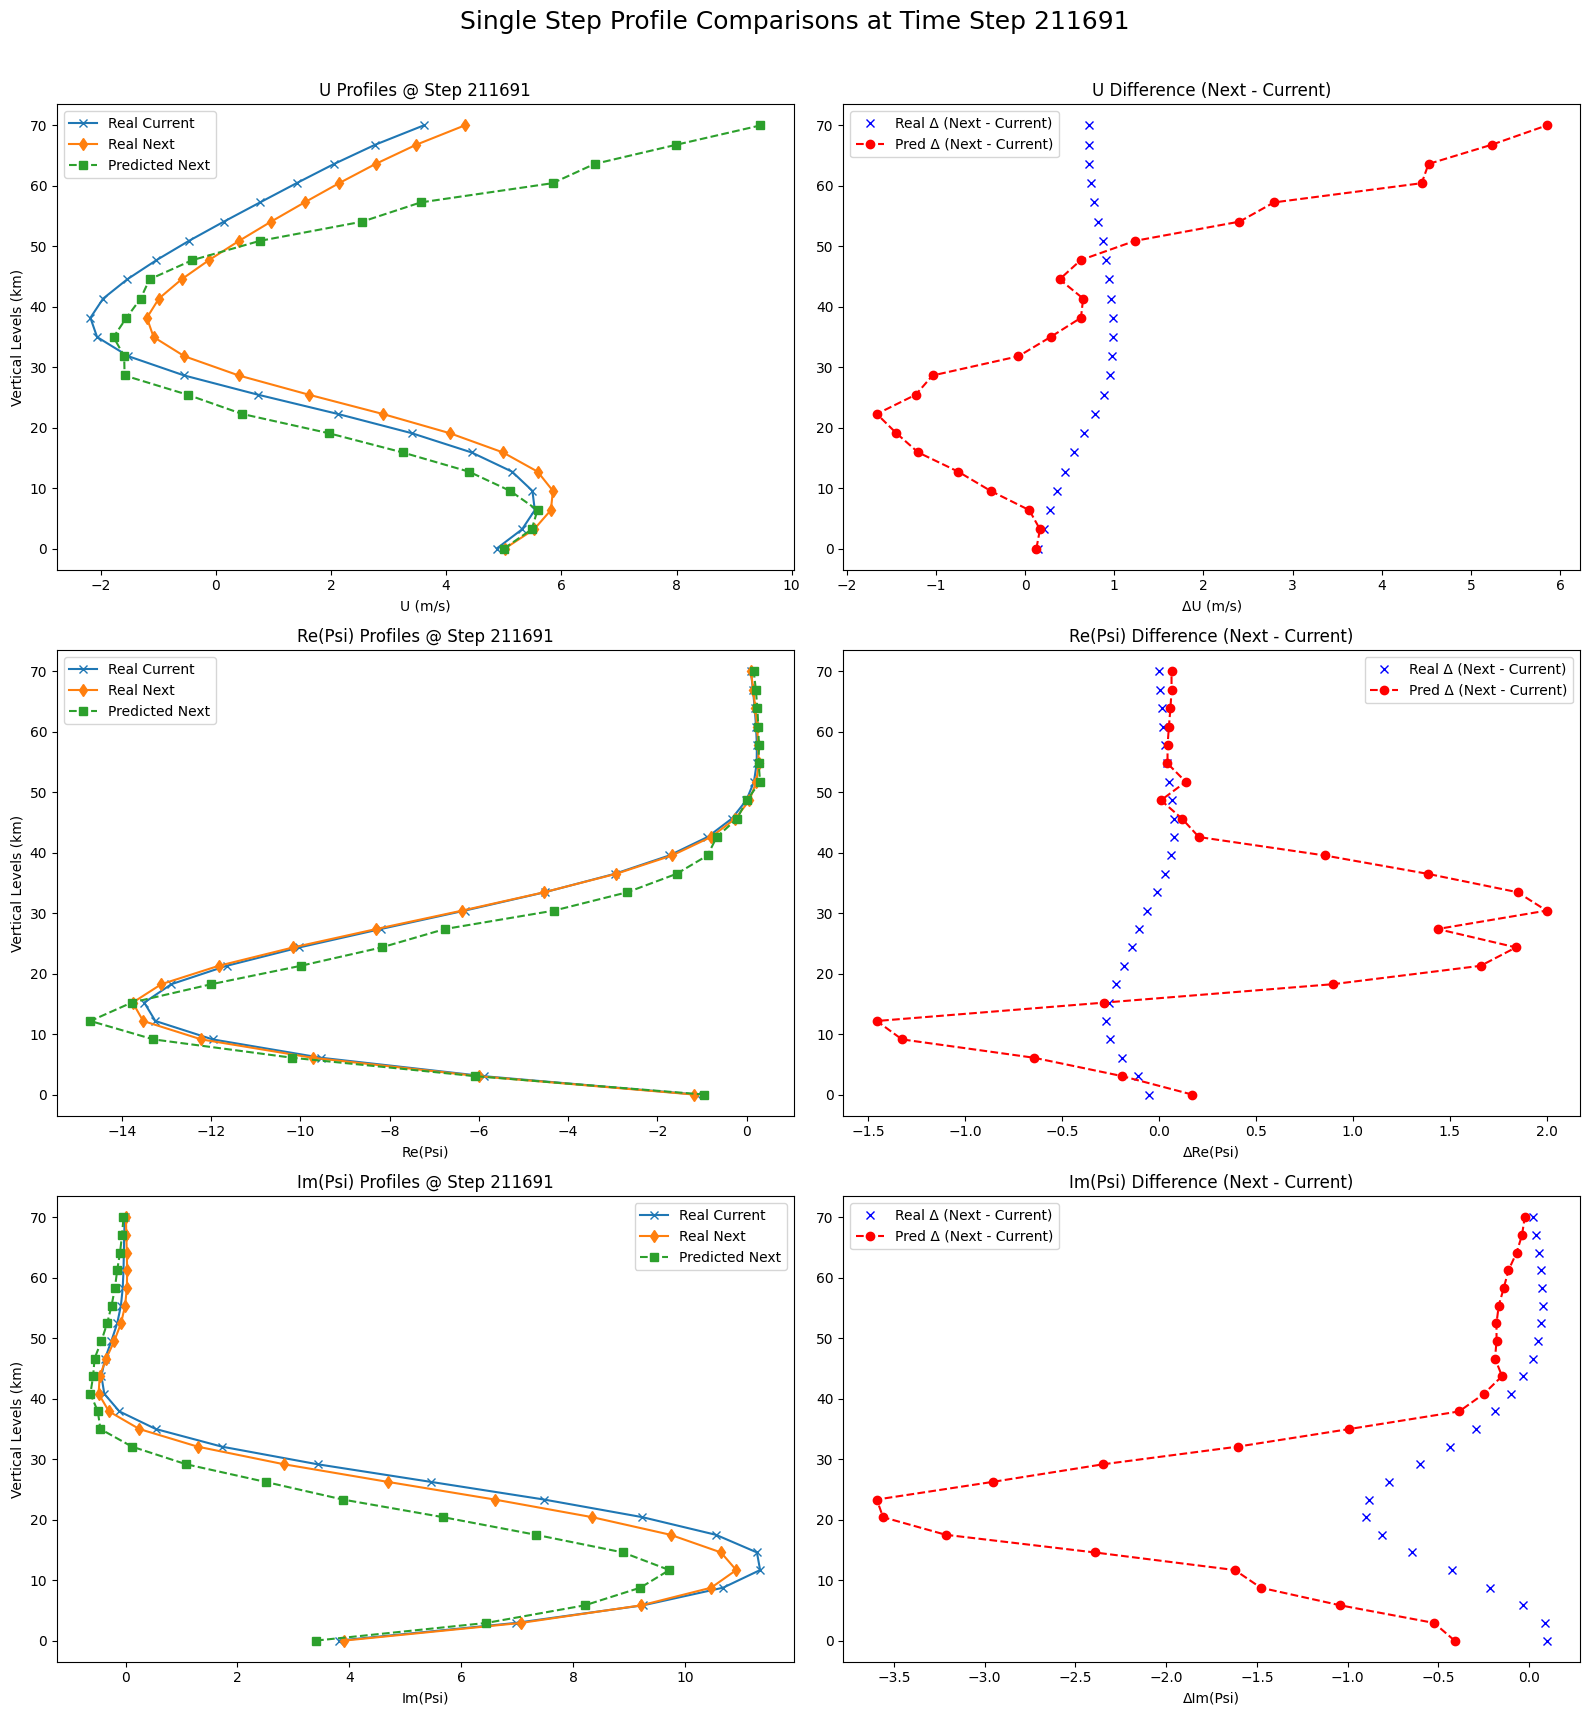

Combined plot saved for sampled point 211691


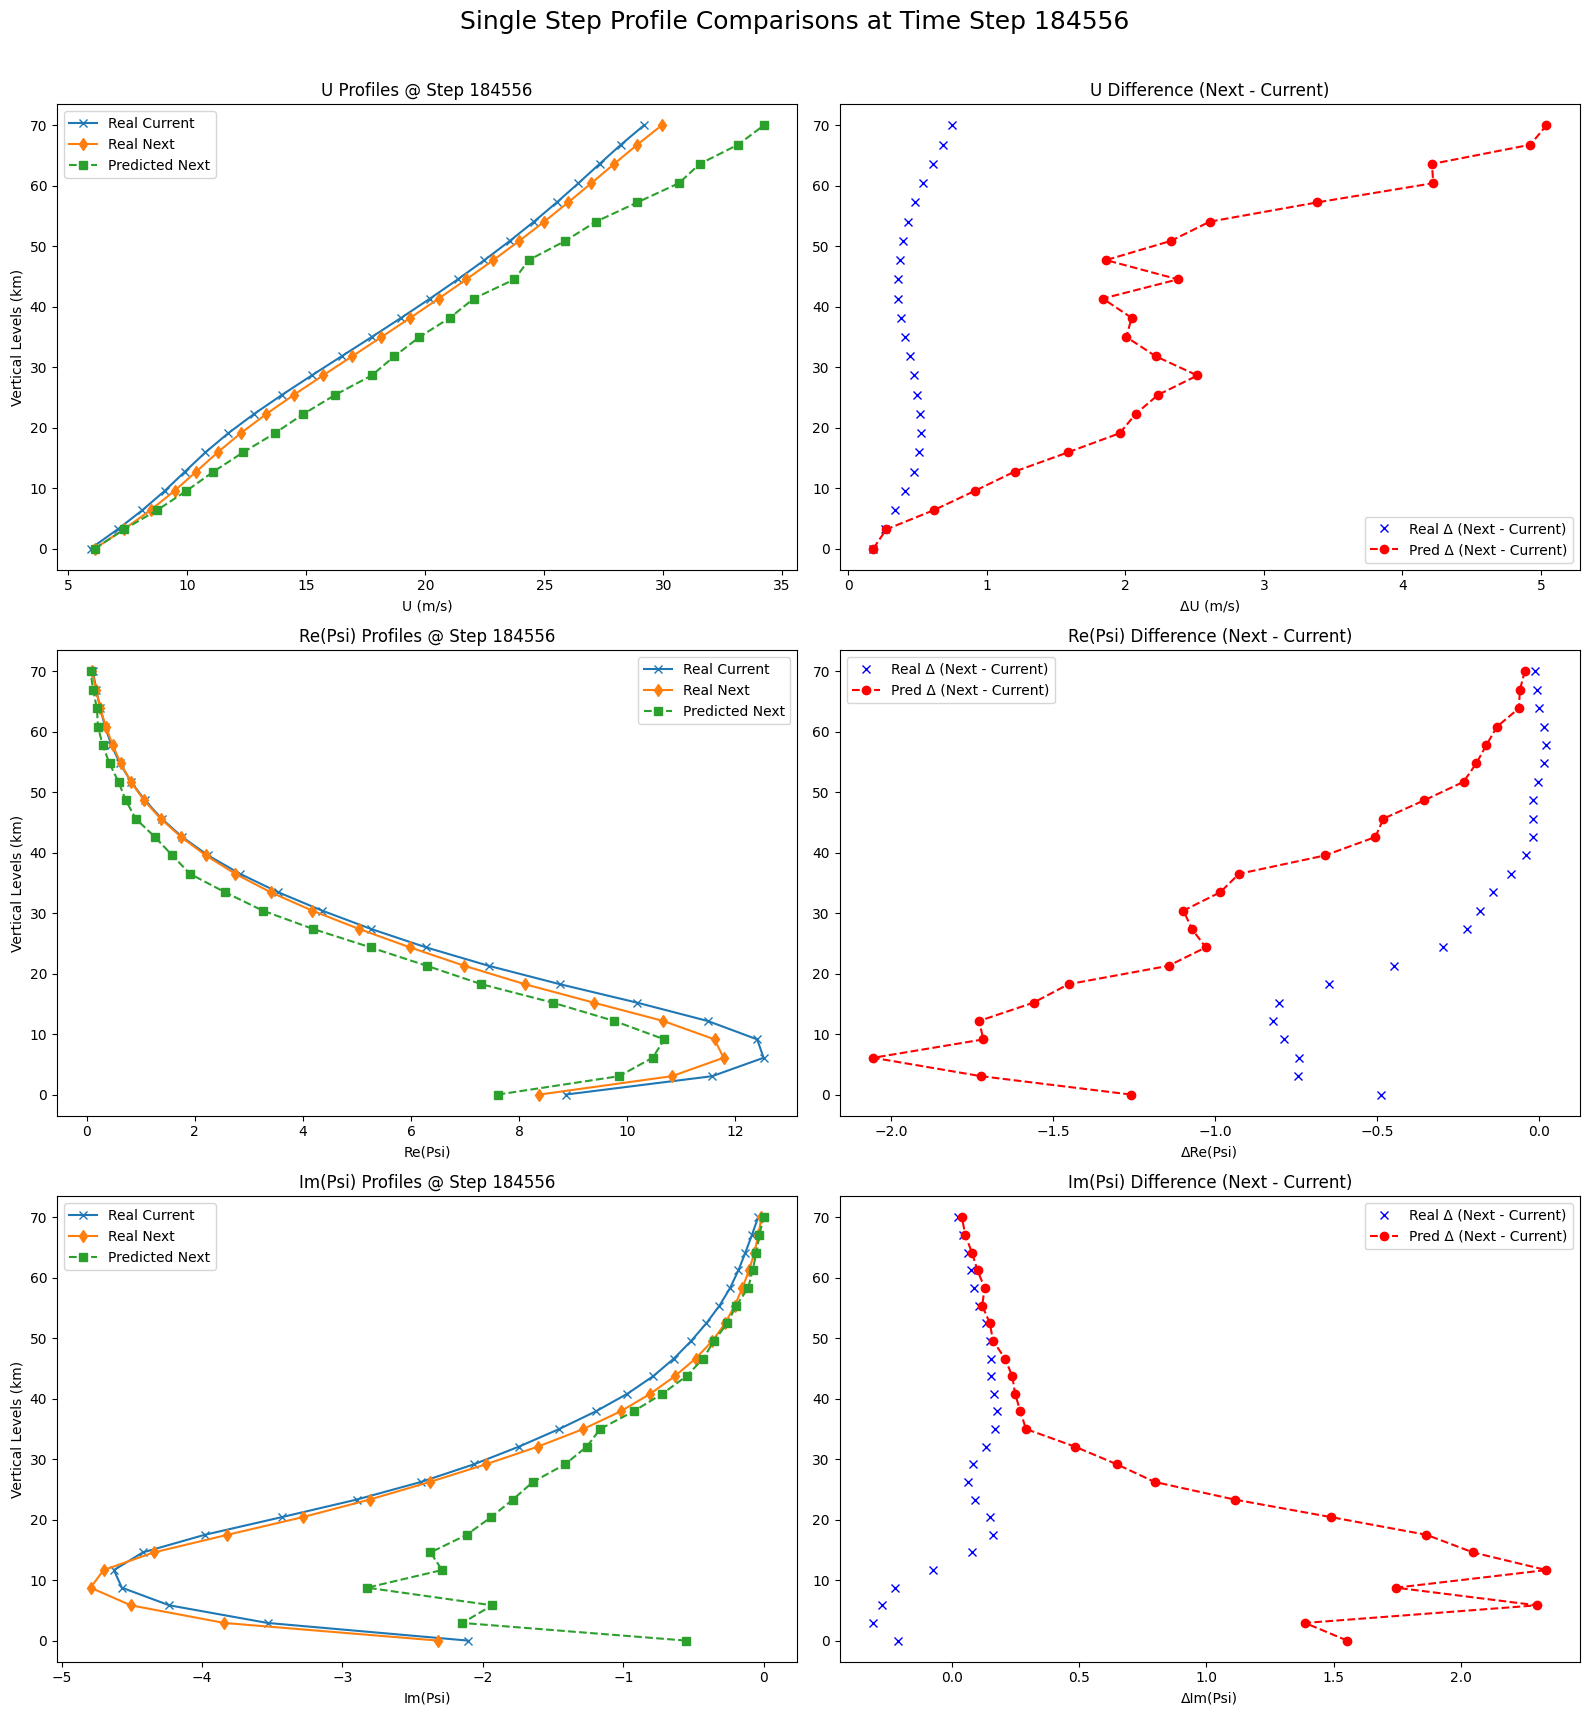

Combined plot saved for sampled point 184556


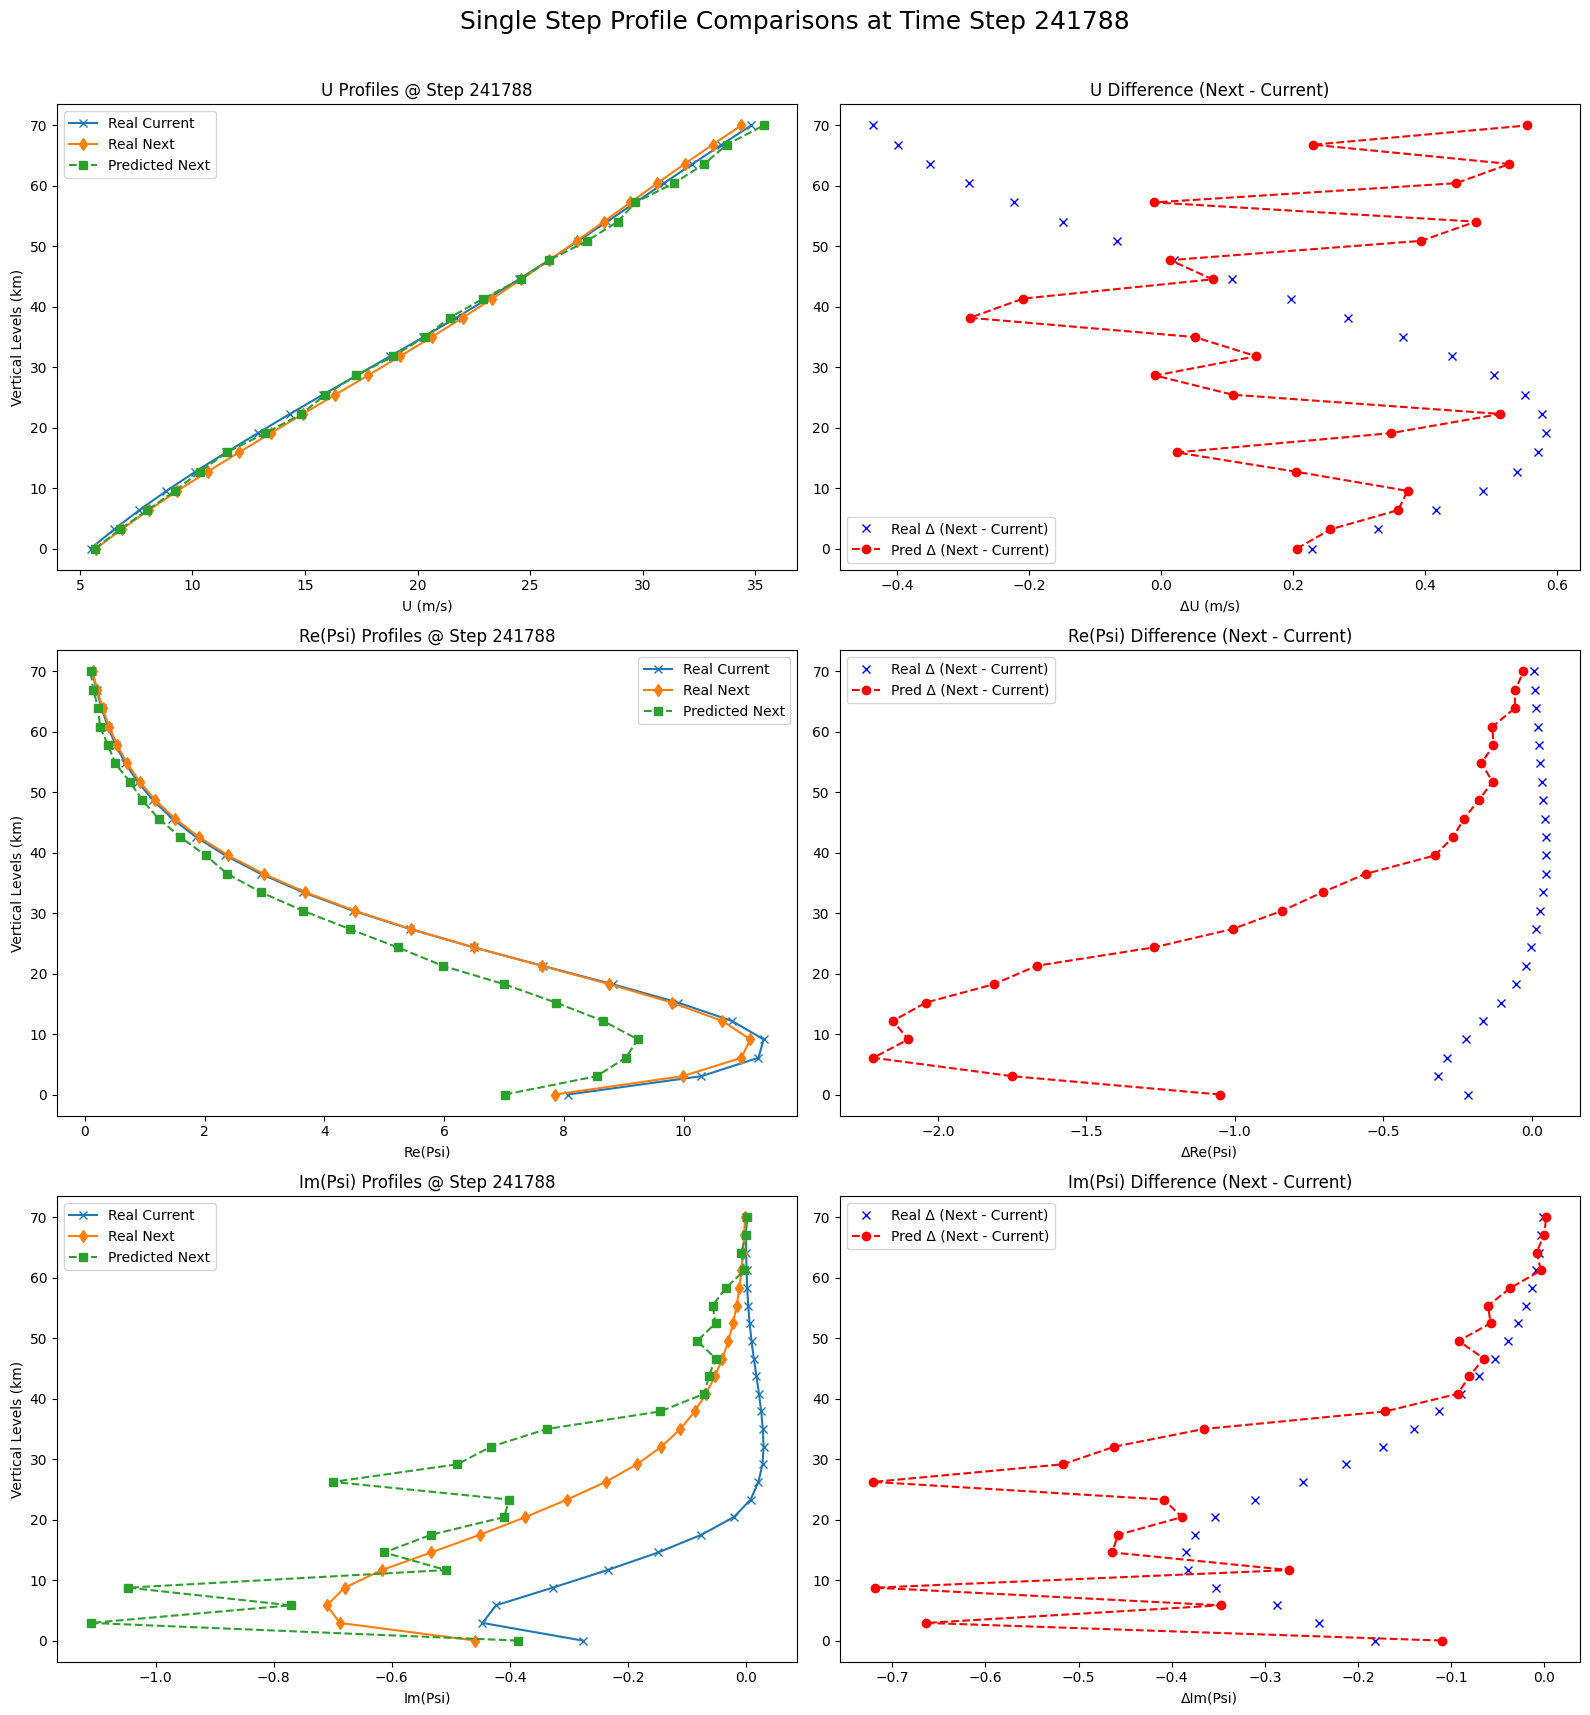

Combined plot saved for sampled point 241788


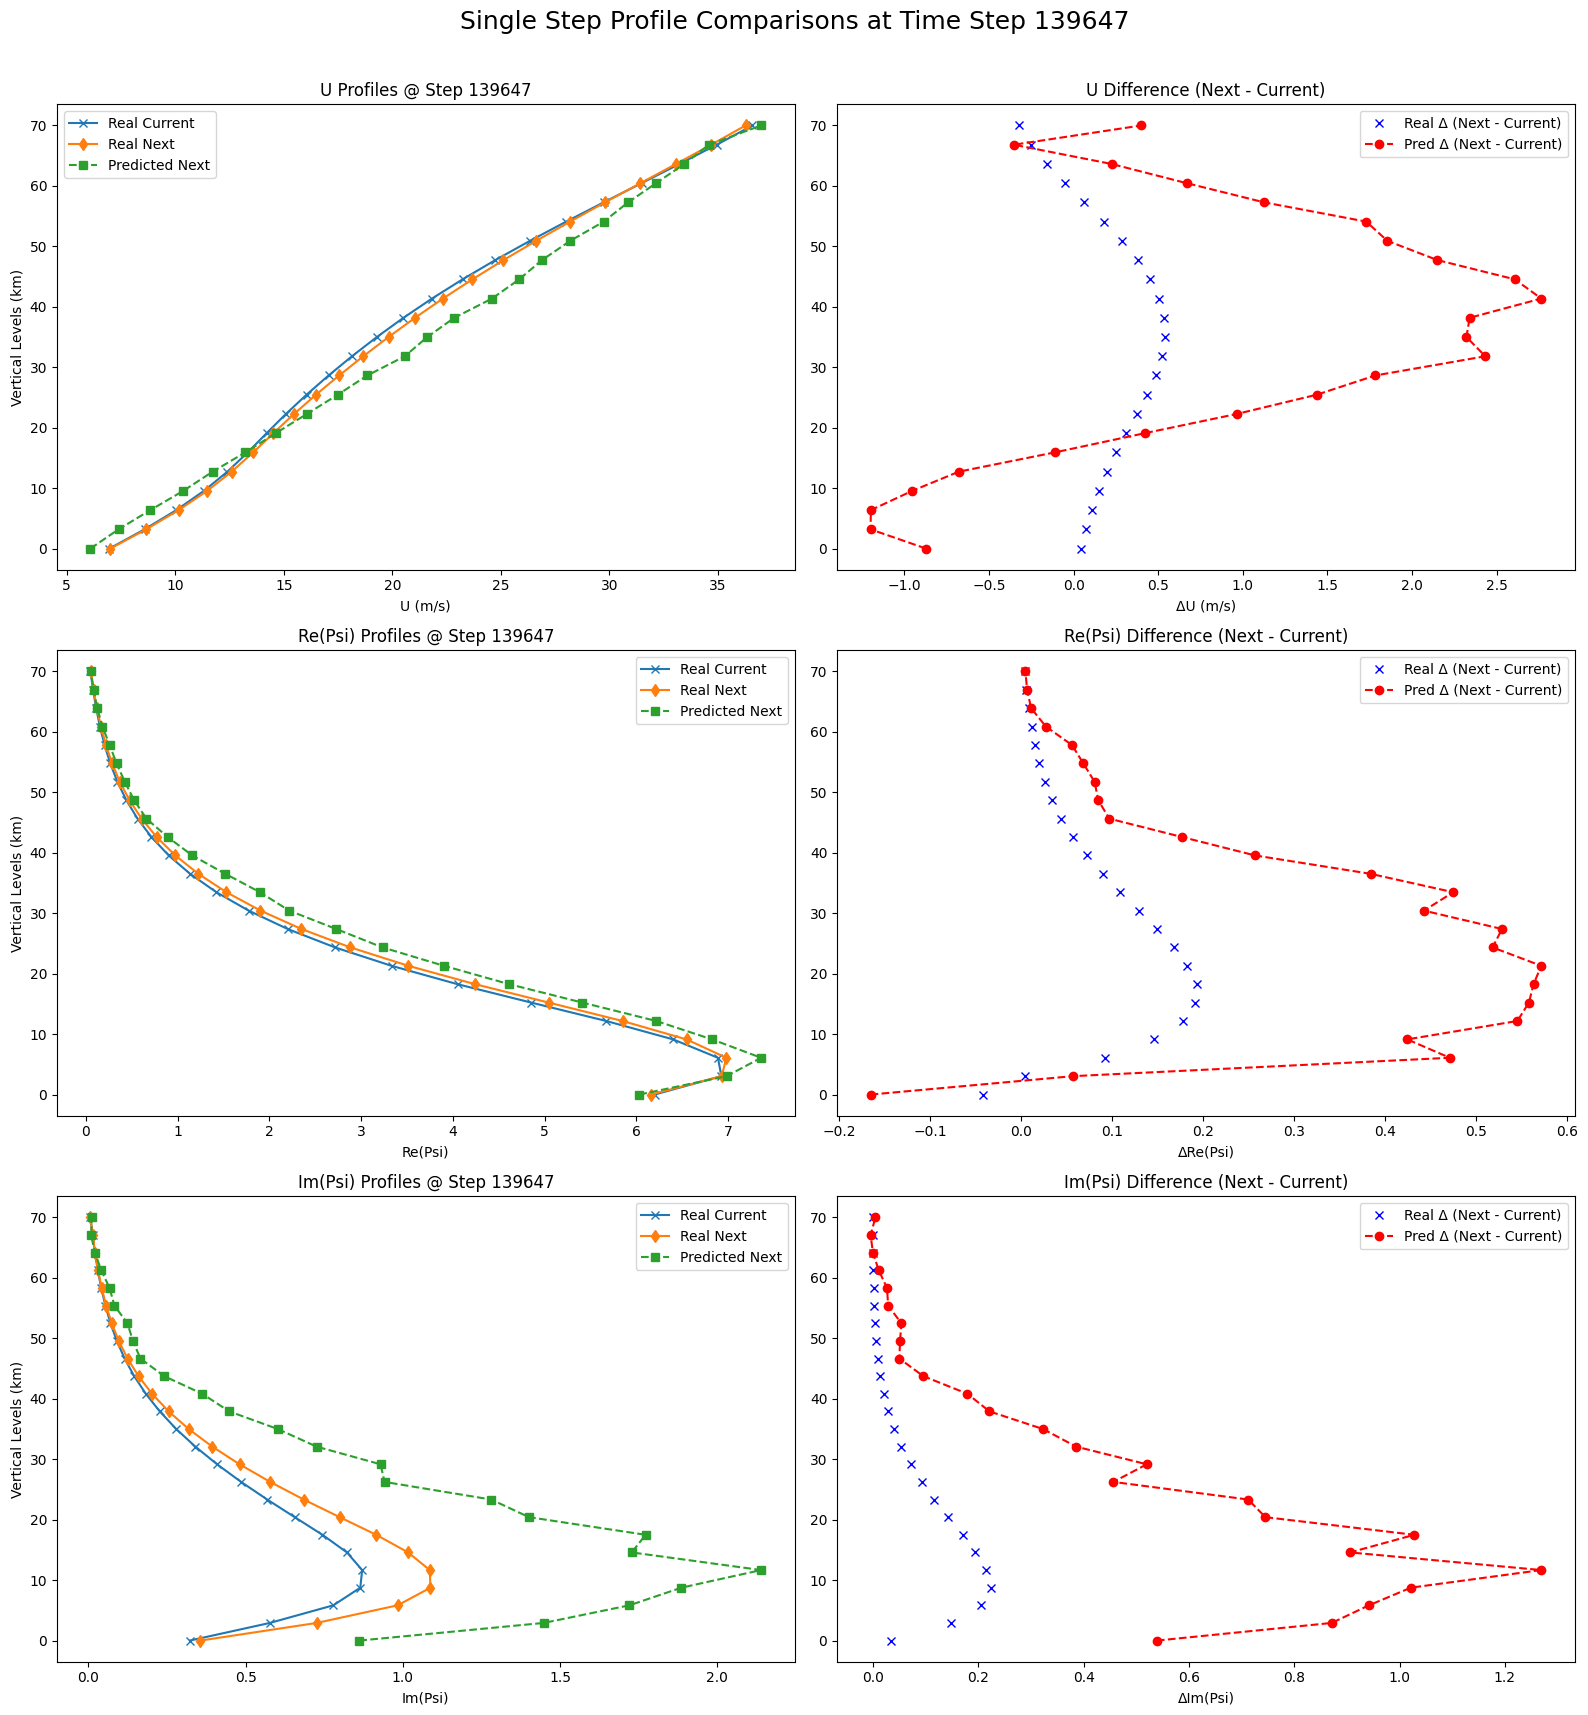

Combined plot saved for sampled point 139647
Finished processing all sampled points.
(300000, 1, 75)
(309700, 2, 75)


In [115]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
if (plot_data):
    #note that the value 300000 will have to change depending on the real and predictions data length
    u_profile_real = real_data[:300000, 1, level]  # Match time length with predictions
    u_profile_pred = predictions[:, 0, level]
    time_steps = np.arange(len(u_profile_pred))

    # === Plot ===
    plt.figure(figsize=(14, 6))

    plt.plot(time_steps, u_profile_real, label='Real Data', alpha=0.7)
    plt.plot(time_steps, u_profile_pred, label='Predictions', linestyle='--')


    # Labels, legend, and formatting
    plt.xlabel('Time step')
    plt.ylabel('U (m/s)')
    plt.title(f'Time Series of U at Vertical Level {level}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    save_path = os.path.join(folder, "timeseries")
    save_path = os.path.join(save_path, "real_prediction_plot")
    plt.savefig(save_path)
    plt.show()

if (CCDF):
    real_data_1d = real_data[:, 1, 61]  # Now shape is (309700,)
    predictions_1d = predictions[:, 0, 61]  # shape (300000,)

    # Define bounds (assuming they apply to both datasets)
    upper_bound = 53.8 / 2.8935
    lower_bound = 1.75 / 2.8935

    # Function to calculate transition durations
    def calculate_transition_durations(y_values, upper_bound, lower_bound):
        times_between_transitions = []
        transition_start = None
        above_upper = False
        below_lower = False

        for i in range(1, len(y_values)):
            if y_values[i] < lower_bound:  
                below_lower = True
                above_upper = False
            elif y_values[i] > upper_bound:  
                if below_lower and transition_start is not None:
                    times_between_transitions.append(i - transition_start)
                    transition_start = None  
                above_upper = True
                below_lower = False

            if below_lower and transition_start is None:
                transition_start = i

        return times_between_transitions

    # Compute transition durations for real data
    real_durations = calculate_transition_durations(real_data_1d, upper_bound, lower_bound)

    # Compute transition durations for predictions data
    pred_durations = calculate_transition_durations(predictions_1d, upper_bound, lower_bound)

    # Plot setup
    plt.figure(figsize=(10, 6))

    # === REAL DATA CCDF AND FIT ===
    if len(real_durations) == 0:
        print("No transitions detected in real data with current bounds!")
    else:
        real_data_sorted = np.sort(real_durations)
        ccdf_real = 1 - np.arange(1, len(real_data_sorted) + 1) / len(real_data_sorted)

        valid_indices_real = ccdf_real > 0
        x_fit_real = real_data_sorted[valid_indices_real]
        y_fit_real = np.log(ccdf_real[valid_indices_real])

        slope_real, intercept_real, *_ = linregress(x_fit_real, y_fit_real)

        x_line_real = np.linspace(min(x_fit_real), max(x_fit_real), 100)
        y_line_real = np.exp(slope_real * x_line_real + intercept_real)

        plt.step(real_data_sorted, ccdf_real, where='post', label='Real Data CCDF', linewidth=2, linestyle='--')
        plt.plot(x_line_real, y_line_real, 'b-', label=f'Real Exp Fit (slope={slope_real:.4f})', linewidth=2)

    # === PREDICTIONS CCDF AND FIT ===
    if len(pred_durations) == 0:
        print("No transitions detected in predictions with current bounds!")
    else:
        pred_data_sorted = np.sort(pred_durations)
        ccdf_pred = 1 - np.arange(1, len(pred_data_sorted) + 1) / len(pred_data_sorted)

        valid_indices_pred = ccdf_pred > 0
        x_fit_pred = pred_data_sorted[valid_indices_pred]
        y_fit_pred = np.log(ccdf_pred[valid_indices_pred])

        slope_pred, intercept_pred, *_ = linregress(x_fit_pred, y_fit_pred)

        x_line_pred = np.linspace(min(x_fit_pred), max(x_fit_pred), 100)
        y_line_pred = np.exp(slope_pred * x_line_pred + intercept_pred)

        plt.step(pred_data_sorted, ccdf_pred, where='post', label='Predictions CCDF', linewidth=2, linestyle='-.', color='red')
        plt.plot(x_line_pred, y_line_pred, 'r-', label=f'Pred Exp Fit (slope={slope_pred:.4f})', linewidth=2)

    # Plot labels and formatting
    plt.xlabel('Time Duration (Steps)')
    plt.ylabel('CCDF')
    plt.title('CCDF of Time Between B->A and A->B Transitions (Exponential Fit)')
    plt.yscale("log")  # y-axis log scale
    plt.xscale("linear")  # x-axis linear scale
    plt.grid()
    plt.legend()
    plt.tight_layout()
    save_path = os.path.join(folder, "CCDF")
    save_path = os.path.join(save_path, "CCDF_plot")
    plt.savefig(save_path)
    plt.show()
if (Bi_modal_distribution):
    zonal_wind_data_real = real_data[:, 1, 63]  # variable index 1 (e.g., zonal wind), level 60
    zonal_wind_data_predictions = predictions[:, 0, 63]  # variable index 0 (predictions), level 60

    print(f"Shape of zonal_wind_data_real: {zonal_wind_data_real.shape}")
    print(f"Shape of zonal_wind_data_predictions: {zonal_wind_data_predictions.shape}")

    # Plot the bimodal histogram
    plt.figure(figsize=(12, 6))

    # Create histograms (overlaid)
    sns.histplot(zonal_wind_data_real, bins=50, kde=True, color='black', alpha=0.6, element='step', label='Real Data')
    sns.histplot(zonal_wind_data_predictions, bins=50, kde=True, color='red', alpha=0.6, element='step', label='Predictions')

    # Customize plot labels and title
    plt.title('Distribution of Zonal Winds For Real Data and Predictions', fontsize=16)
    plt.xlabel('Zonal Wind (m/s)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # Add vertical lines at means
    plt.axvline(np.mean(zonal_wind_data_real), color='black', linestyle='--', label=f'Real Mean: {np.mean(zonal_wind_data_real):.2f}')
    plt.axvline(np.mean(zonal_wind_data_predictions), color='red', linestyle='--', label=f'Pred Mean: {np.mean(zonal_wind_data_predictions):.2f}')

    # Final plot settings
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    save_path = os.path.join(folder, "bi_modal_distribution")
    save_path = os.path.join(save_path, "bi_modal_distribution_plot")
    plt.savefig(save_path)
    plt.show()
if (single_step_profiles):
    # Ensure save directory exists
    os.makedirs(SAVE_DIR, exist_ok=True)

    # === Load model weights ===
    vae.load_state_dict(torch.load(MODEL_PATH))
    vae.eval()

    # === Randomly sample time points from real data ===
    time_indices = random.sample(range(0, real_data.shape[0] - 2), NUM_SAMPLES)
    print(f"Randomly sampled time steps: {time_indices}")

    # === Time series visualization ===
    real_data_timeseries = real_data[:, 1, LEVEL]
    time_steps_all = np.arange(len(real_data_timeseries))

    plt.figure(figsize=(12, 6))
    plt.plot(time_steps_all, real_data_timeseries, label="Real Data at Level 61", color='blue')

    # Mark sample points
    for idx_num, idx in enumerate(time_indices):
        plt.axvline(x=idx, color='green', linestyle='--', linewidth=2)
    if len(time_indices) > 0:
        plt.axvline(x=time_indices[0], color='green', linestyle='--', linewidth=2, label='Sampled Points')

    plt.title("Real Data Time Series with Sampled Points Highlighted")
    plt.xlabel("Time Step")
    plt.ylabel("U (m/s) at Level 61")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    save_path = os.path.join(SAVE_DIR, "real_data_timeseries_with_samples.png")
    plt.savefig(save_path)
    plt.show()

    # === Iterate over each sampled time point ===
    for i, time_step in enumerate(time_indices):
        next_time_step = time_step + 1

        # === Real data: current and next ===
        real_current = real_data[time_step, 1, :]       
        real_next = real_data[next_time_step, 1, :]      

        # === Normalize real_current and make prediction for next step ===
        initial_condition_normalized = (real_current.reshape(1, 75, 1) - mean_psi.reshape(1, -1, 1)) / std_psi.reshape(1, -1, 1)
        current_input = torch.tensor(initial_condition_normalized, dtype=torch.float32).to(device)

        with torch.no_grad():
            mu, log_var = vae.encoder(current_input)
            z = vae.reparameterize(mu, log_var)
            pred_next = vae.decoder(z)

        # === Denormalize predicted next ===
        pred_next_denorm = pred_next.squeeze().cpu().numpy() * std_psi.squeeze() + mean_psi.squeeze()

        # === Extract U, Re(Psi), Im(Psi) components ===
        # U profiles
        U_current_real = real_current[51:74]
        U_next_real = real_next[51:74]
        U_next_pred = pred_next_denorm[51:74]

        # Re(Psi) profiles
        RePsi_current_real = real_current[0:24]
        RePsi_next_real = real_next[0:24]
        RePsi_next_pred = pred_next_denorm[0:24]

        # Im(Psi) profiles
        ImPsi_current_real = real_current[25:50]
        ImPsi_next_real = real_next[25:50]
        ImPsi_next_pred = pred_next_denorm[25:50]

        # === Differences ===
        U_diff_real = U_next_real - U_current_real
        U_diff_pred = U_next_pred - U_current_real

        RePsi_diff_real = RePsi_next_real - RePsi_current_real
        RePsi_diff_pred = RePsi_next_pred - RePsi_current_real

        ImPsi_diff_real = ImPsi_next_real - ImPsi_current_real
        ImPsi_diff_pred = ImPsi_next_pred - ImPsi_current_real

        # === Create a single figure with 3 rows (U, Re(Psi), Im(Psi)) ===
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))  # 3 rows, 2 columns (Profile and Difference)

        z_levels_U = np.linspace(0, 70, 23)
        z_levels_RePsi = np.linspace(0, 70, 24)
        z_levels_ImPsi = np.linspace(0, 70, 25)

        # --- U ---
        axes[0, 0].plot(U_current_real, z_levels_U, 'x-', label="Real Current")
        axes[0, 0].plot(U_next_real, z_levels_U, 'd-', label="Real Next")
        axes[0, 0].plot(U_next_pred, z_levels_U, 's--', label="Predicted Next")
        axes[0, 0].set_title(f"U Profiles @ Step {time_step}")
        axes[0, 0].set_xlabel("U (m/s)")
        axes[0, 0].set_ylabel("Vertical Levels (km)")
        axes[0, 0].legend()

        axes[0, 1].plot(U_diff_real, z_levels_U, 'xb', label="Real Δ (Next - Current)")
        axes[0, 1].plot(U_diff_pred, z_levels_U, 'o--r', label="Pred Δ (Next - Current)")
        axes[0, 1].set_title("U Difference (Next - Current)")
        axes[0, 1].set_xlabel("ΔU (m/s)")
        axes[0, 1].legend()

        # --- Re(Psi) ---
        axes[1, 0].plot(RePsi_current_real, z_levels_RePsi, 'x-', label="Real Current")
        axes[1, 0].plot(RePsi_next_real, z_levels_RePsi, 'd-', label="Real Next")
        axes[1, 0].plot(RePsi_next_pred, z_levels_RePsi, 's--', label="Predicted Next")
        axes[1, 0].set_title(f"Re(Psi) Profiles @ Step {time_step}")
        axes[1, 0].set_xlabel("Re(Psi)")
        axes[1, 0].set_ylabel("Vertical Levels (km)")
        axes[1, 0].legend()

        axes[1, 1].plot(RePsi_diff_real, z_levels_RePsi, 'xb', label="Real Δ (Next - Current)")
        axes[1, 1].plot(RePsi_diff_pred, z_levels_RePsi, 'o--r', label="Pred Δ (Next - Current)")
        axes[1, 1].set_title("Re(Psi) Difference (Next - Current)")
        axes[1, 1].set_xlabel("ΔRe(Psi)")
        axes[1, 1].legend()

        # --- Im(Psi) ---
        axes[2, 0].plot(ImPsi_current_real, z_levels_ImPsi, 'x-', label="Real Current")
        axes[2, 0].plot(ImPsi_next_real, z_levels_ImPsi, 'd-', label="Real Next")
        axes[2, 0].plot(ImPsi_next_pred, z_levels_ImPsi, 's--', label="Predicted Next")
        axes[2, 0].set_title(f"Im(Psi) Profiles @ Step {time_step}")
        axes[2, 0].set_xlabel("Im(Psi)")
        axes[2, 0].set_ylabel("Vertical Levels (km)")
        axes[2, 0].legend()

        axes[2, 1].plot(ImPsi_diff_real, z_levels_ImPsi, 'xb', label="Real Δ (Next - Current)")
        axes[2, 1].plot(ImPsi_diff_pred, z_levels_ImPsi, 'o--r', label="Pred Δ (Next - Current)")
        axes[2, 1].set_title("Im(Psi) Difference (Next - Current)")
        axes[2, 1].set_xlabel("ΔIm(Psi)")
        axes[2, 1].legend()

        # === Finalize and Save ===
        plt.suptitle(f"Single Step Profile Comparisons at Time Step {time_step}", fontsize=18)
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])

        save_path = os.path.join(SAVE_DIR, f"Profile_Summary_point_{time_step}.png")
        plt.savefig(save_path)
        plt.show()

        print(f"Combined plot saved for sampled point {time_step}")

    # Final debug
    print("Finished processing all sampled points.")
        # Debugging prints
    print(predictions.shape) 
    print(real_data.shape)